# Cálculo de Isocronas a partir de Pontos de Interesse (Hospitais)

Este notebook demonstra como calcular isócronas de tempo de viagem a partir de um conjunto de pontos de interesse (neste caso, localizações de hospitais/UBS) utilizando a malha viária.

### Objetivo:
Gerar polígonos de isócrona que representam as áreas acessíveis dentro de 10, 20 e 30 minutos de viagem a partir de cada hospital.

### Pilha de Tecnologias:
- `city2graph`: Para criação do grafo viário e cálculo das isócronas.
- `networkx`: Biblioteca subjacente para manipulação de grafos.
- `geopandas`: Para manipulação de dados geoespaciais.
- `pandas`: Para manipulação de dados tabulares.
- `shapely`: Para operações geométricas.
- `pyarrow`: Para leitura eficiente de dados Parquet (formato da Overture Maps).
- `numpy`: Para operações numéricas.
- `scipy`: Utilizado internamente por outras bibliotecas.
- `seaborn` & `matplotlib`: Para visualização dos dados.

## 1. Configuração e Importações

In [2]:
# Instalação das bibliotecas (caso não tenha instalado)
# Descomente a linha abaixo para instalar
# !pip install city2graph networkx geopandas pandas shapely pyarrow numpy scipy seaborn matplotlib

import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt

import city2graph as c2g

# Configurações de visualização
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 12)

print("Bibliotecas importadas com sucesso!")

Bibliotecas importadas com sucesso!


## 2. Obtenção e Preparação dos Dados

Vamos preparar nossos dois conjuntos de dados principais: os pontos das UBS e a malha viária.

### 2.1. Dados de Entrada: Localização dos UBS

Carregando os dados geográficos de um GEOJSON.

CRS = EPSG:4674
Dados das UBS Originais:


,fid,nome,cnes,logradouro,numero,bairro,cep,regional,geometry
0,1,UBS A BENICIO FREIRE E SILVA-POTY VELHO,2588811,RUA MARIO AUGUSTO FREITAS,1469,POTY VELHO,64005830,NORTE,POINT (-42.82786 -5.03685)
1,2,UBS DR. CARLOS ALBERTO CORDEIRO,6404057,RUA EDMILSON PAIXAO,S/N,DIRCEUII,64078271,SUDESTE,POINT (-42.75886 -5.10925)
2,3,UBS DR DURVALINO COUTO,2406624,AV ERCINIO FORTES,S/N,BELA VISTA,64031090,SUL,POINT (-42.77652 -5.13522)
3,4,UBS DR EVALDO CARVALHO- NOVA BRASILIA,2406845,RUA ANISIO PIRES,S N,NOVA BRASILIA,64004550,NORTE,POINT (-42.83015 -5.05393)
4,5,UBS DR FELIPE EULALIO DE PADUA-PROMORAR,6901468,PRACA DO CENTRO DE PRODUCAO DO PROMORAR,QD 61,PROMORAR,64027140,SUL,POINT (-42.78175 -5.14785)


CRS definido para EPSG:31983
Dados das UBS Reprojetados:


,fid,nome,cnes,logradouro,numero,bairro,cep,regional,geometry
0,1,UBS A BENICIO FREIRE E SILVA-POTY VELHO,2588811,RUA MARIO AUGUSTO FREITAS,1469,POTY VELHO,64005830,NORTE,POINT (740835.065 9442861.74)
1,2,UBS DR. CARLOS ALBERTO CORDEIRO,6404057,RUA EDMILSON PAIXAO,S/N,DIRCEUII,64078271,SUDESTE,POINT (748460.94 9434826.331)
2,3,UBS DR DURVALINO COUTO,2406624,AV ERCINIO FORTES,S/N,BELA VISTA,64031090,SUL,POINT (746492.593 9431960.513)
3,4,UBS DR EVALDO CARVALHO- NOVA BRASILIA,2406845,RUA ANISIO PIRES,S N,NOVA BRASILIA,64004550,NORTE,POINT (740574.523 9440972.801)
4,5,UBS DR FELIPE EULALIO DE PADUA-PROMORAR,6901468,PRACA DO CENTRO DE PRODUCAO DO PROMORAR,QD 61,PROMORAR,64027140,SUL,POINT (745907.107 9430564.831)


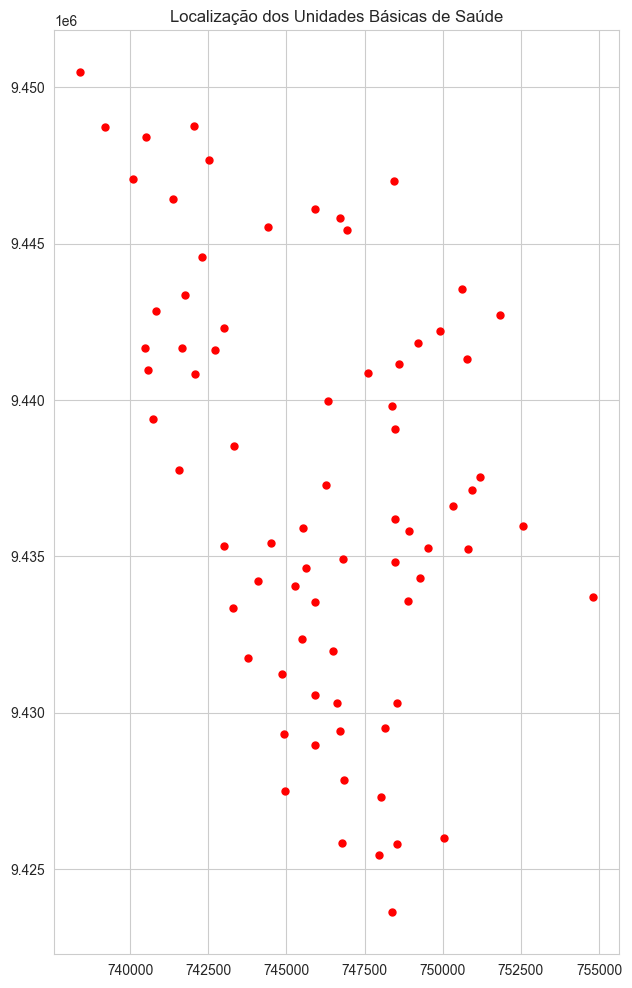

In [5]:
# Indicação do Caminho relativo dos dados de UBS dentro da zona urbana de Teresina
ubs_path = "dados/semplam/ubs_zu.geojson"

# Carregando o geojson em um dataframe geopandas
ubs_gdf= gpd.read_file(ubs_path)
print(f"CRS = {ubs_gdf.crs}")
print("Dados das UBS Originais:")
display(ubs_gdf.head())

# Garantir que o CRS está correto
if ubs_gdf.crs is None:
    print("CRS definido para EPSG:31983")
    ubs_gdf.set_crs('EPSG:31983', inplace=True)
else:
    ubs_gdf = ubs_gdf.to_crs('EPSG:31983')
    print(f"CRS definido para {ubs_gdf.crs}")
print("Dados das UBS Reprojetados:")
display(ubs_gdf.head())

# Plotando os pontos no mapa
ubs_gdf.plot(color='red', markersize=25)
plt.title("Localização dos Unidades Básicas de Saúde")
plt.show()

### 2.2. Malha Viária (Overture Maps Foundation)

A Overture Maps fornece dados geoespaciais abertos em formato Parquet. O recorte da malha viária (segmentos de transporte) para a área de interesse foi baixado previamente através do utilitário de linha de comando 'overturemaps-py' no formado GeoJson.

In [3]:
# URL para o tile da malha viária de São Paulo da Overture Maps
# Este é um link para um recorte específico (tile) para manter o exemplo leve.
# O 'theme=transportation&type=segment' indica que queremos os segmentos de rua.
overture_url = "dados/overturemaps/teresina_zu_segments_road.parquet"

# Lendo os dados diretamente do URL para um GeoDataFrame
# O pyarrow é usado aqui nos bastidores pelo geopandas
print("Baixando e carregando a malha viária da Overture Maps (pode levar um momento)...")
gdf_segments = gpd.read_parquet(overture_url)
gdf_segments.head(3)

Baixando e carregando a malha viária da Overture Maps (pode levar um momento)...


,id,version,sources,subtype,class,names.primary,names.common,names.rules,connectors,routes,...,level_rules,destinations,prohibited_transitions,road_surface,road_flags,speed_limits,width_rules,subclass,rail_flags,geometry
0,bec04a17-e771-4832-8629-04180feba2b0,1,"[{""property"":""""},{""property"":""routes""}]",road,trunk,None,None,None,"[{""connector_id"":""400bb6af-ade0-4d0f-af20-b25a...","[{""name"":null}]",...,None,None,None,"[{""value"":""paved""}]",None,"[{""min_speed"":null}]",None,None,None,"LINESTRING (-42.74407 -5.23469, -42.74414 -5.2..."
1,86ac160f-49e7-4bb2-9373-6dfb1d5cbf49,1,"[{""property"":""""}]",road,track,None,None,None,"[{""connector_id"":""c35320f8-a016-499b-9d34-8805...",None,...,None,None,None,None,None,None,None,None,None,"LINESTRING (-42.73664 -5.2233, -42.73647 -5.22..."
2,9f21d864-3433-4abe-a5ef-9aac7c1b3e08,1,"[{""property"":""""}]",road,residential,None,None,None,"[{""connector_id"":""bfff2d6d-6766-4217-b2b6-4b6c...",None,...,None,None,None,None,None,None,None,None,None,"LINESTRING (-42.7663 -5.21024, -42.76632 -5.21..."


In [4]:
# >>> INÍCIO DO NOVO CÓDIGO DE FILTRAGEM <<<
print(f"Número de segmentos de via antes da 1ª filtragem: {len(gdf_segments)}")

# 1. PRIMEIRO FILTRO: Manter apenas subtype == 'road'
gdf_rede_step1 = gdf_segments[gdf_segments['subtype'] == 'road'].copy()
print(f"Número de segmentos após filtrar por subtype='road': {len(gdf_rede_step1)}")


# 2. SEGUNDO FILTRO: Sobre o resultado anterior, filtrar pela classe da via
vias_para_manter = [
    'primary', 
    'secondary', 
    'tertiary', 
    'trunk', 
    'residential', 
    'unclassified'
]
# Filtra o GeoDataFrame do passo 1, mantendo apenas as classes desejadas
gdf_rede_filtrada = gdf_rede_step1[gdf_rede_step1['class'].isin(vias_para_manter)].copy()

print(f"Número de segmentos após filtrar por 'class' (resultado final): {len(gdf_rede_filtrada)}")

Número de segmentos de via antes da 1ª filtragem: 40075
Número de segmentos após filtrar por subtype='road': 40072
Número de segmentos após filtrar por 'class' (resultado final): 39618



Malha viária carregada com 39618 segmentos.


,id,version,sources,subtype,class,names.primary,names.common,names.rules,connectors,routes,...,level_rules,destinations,prohibited_transitions,road_surface,road_flags,speed_limits,width_rules,subclass,rail_flags,geometry
0,bec04a17-e771-4832-8629-04180feba2b0,1,"[{""property"":""""},{""property"":""routes""}]",road,trunk,None,None,None,"[{""connector_id"":""400bb6af-ade0-4d0f-af20-b25a...","[{""name"":null}]",...,None,None,None,"[{""value"":""paved""}]",None,"[{""min_speed"":null}]",None,None,None,"LINESTRING (750052.229 9420943.889, 750044.991..."
2,9f21d864-3433-4abe-a5ef-9aac7c1b3e08,1,"[{""property"":""""}]",road,residential,None,None,None,"[{""connector_id"":""bfff2d6d-6766-4217-b2b6-4b6c...",None,...,None,None,None,None,None,None,None,None,None,"LINESTRING (747597.308 9423657.588, 747594.826..."
3,29e0947b-33c7-4177-80d0-ccdebb68bc3d,1,"[{""property"":""""}]",road,residential,None,None,None,"[{""connector_id"":""937b9f65-2eeb-4be1-894f-7748...",None,...,None,None,None,None,None,None,None,None,None,"LINESTRING (747613.012 9423657.511, 747610.886..."


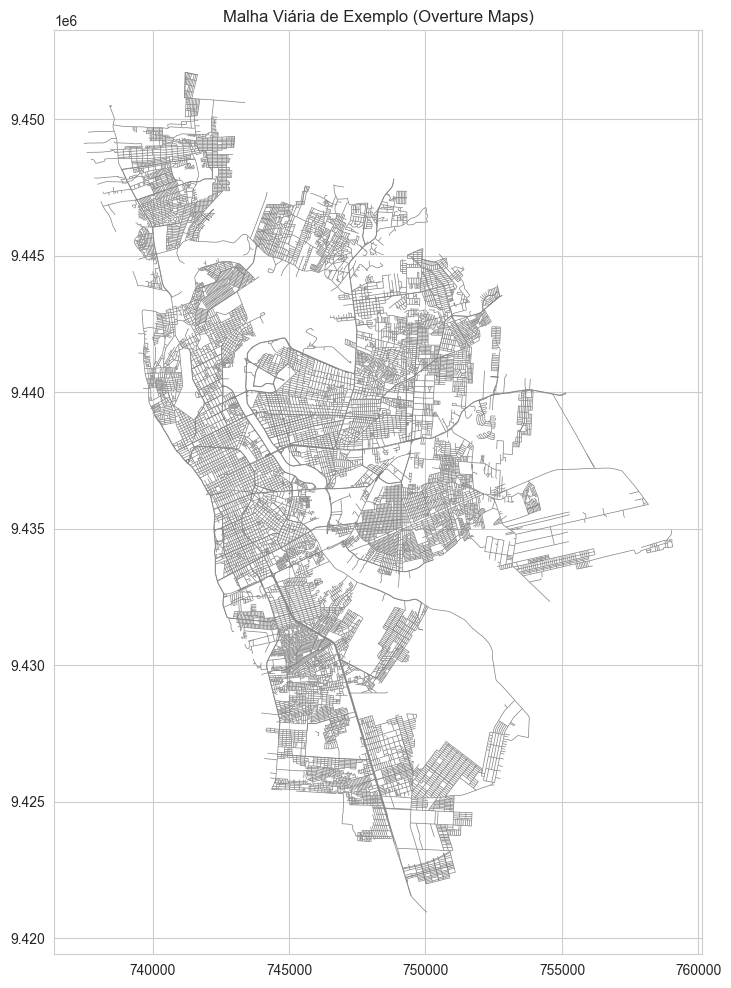

In [5]:
# Garantir que o CRS está correto
if gdf_rede_filtrada.crs is None:
    gdf_rede_filtrada.set_crs('EPSG:31983', inplace=True)
else:
    gdf_rede_filtrada = gdf_rede_filtrada.to_crs('EPSG:31983')

print(f"\nMalha viária carregada com {len(gdf_rede_filtrada)} segmentos.")
display(gdf_rede_filtrada.head(3))

# Filter to keep only road segments (excluding pedestrian paths, railways, etc.)
gdf_rede_filtrada = gdf_rede_filtrada[gdf_rede_filtrada["subtype"] == "road"].copy()

# Plotando a malha viária
gdf_rede_filtrada.plot(linewidth=0.5, color='gray')
plt.title("Malha Viária de Exemplo (Overture Maps)")
plt.show()

## 3. Criação do Grafo Viário com `city2graph`

Agora, vamos converter o `GeoDataFrame` de segmentos de rua em um grafo direcionado e ponderado. A biblioteca `city2graph` facilita muito esse processo.

Vamos assumir uma velocidade média de deslocamento de 40 km/h para calcular o tempo de viagem em cada aresta do grafo. A função `create_graph` criará automaticamente um atributo de peso chamado `travel_time_s` (tempo de viagem em segundos).

## 4. Cálculo das Isocronas

Com o grafo pronto, podemos calcular as isócronas. O processo é:
1.  Para cada hospital, encontrar o nó mais próximo no grafo.
2.  Para cada intervalo de tempo (10, 20, 30 min), usar a função `create_isochrone`.
3.  Armazenar os polígonos resultantes em um novo `GeoDataFrame`.

In [6]:
# CALCULAR O TEMPO DE VIAGEM ---

# Velocidade média que será usada para o cálculo.
# Este valor é crucial para a precisão do resultado.
# Exemplo: 30 km/h (velocidade média em área urbana)
velocidade_kmh = 40.0
velocidade_ms = velocidade_kmh * 1000 / 3600 # Convertendo para metros por segundo

print(f"Calculando o tempo de viagem com base em uma velocidade de {velocidade_kmh} km/h...")

# Como os dados já estão em um CRS projetado (EPSG:31983), o comprimento é em metros.
# tempo (segundos) = distância (metros) / velocidade (metros/segundo)
gdf_rede_filtrada['tempo_viagem_s'] = gdf_rede_filtrada.geometry.length / velocidade_ms

print("Coluna 'tempo_viagem_s' adicionada ao GeoDataFrame 'gdf_segments'.")
gdf_rede_filtrada[['class', 'geometry', 'tempo_viagem_s']].head()

Calculando o tempo de viagem com base em uma velocidade de 40.0 km/h...
Coluna 'tempo_viagem_s' adicionada ao GeoDataFrame 'gdf_segments'.


,class,geometry,tempo_viagem_s
0,trunk,"LINESTRING (750052.229 9420943.889, 750044.991...",123.076349
2,residential,"LINESTRING (747597.308 9423657.588, 747594.826...",8.116540
3,residential,"LINESTRING (747613.012 9423657.511, 747610.886...",8.084980
4,residential,"LINESTRING (747522.844 9423731.705, 747517.44 ...",28.489966
5,residential,"LINESTRING (747669.643 9423555.425, 747782.652...",10.189167


In [7]:
gdf_rede_filtrada.crs


<Projected CRS: EPSG:31983>
Name: SIRGAS 2000 / UTM zone 23S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Brazil - between 48°W and 42°W, northern and southern hemispheres, onshore and offshore.
- bounds: (-48.0, -33.5, -42.0, 5.13)
Coordinate Operation:
- name: UTM zone 23S
- method: Transverse Mercator
Datum: Sistema de Referencia Geocentrico para las AmericaS 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [12]:
# Definir os intervalos de tempo de viagem em minutos
tempos_viagem_min = [10.0, 20.0, 30.0]

# Lista para armazenar os resultados das isócronas
resultados_isocronas = []

# >>> INÍCIO DA MODIFICAÇÃO PARA O TESTE <<<
print(f"\nMODO DE TESTE ATIVADO: Selecionando 5 UBS aleatórias das {len(ubs_gdf)} totais.")
# Cria um novo GeoDataFrame com 5 amostras aleatórias do original.
# random_state=42 garante que a amostra "aleatória" seja sempre a mesma, para testes reprodutíveis.
ubs_amostra_gdf = ubs_gdf.sample(n=9, random_state=42)
# >>> FIM DA MODIFICAÇÃO PARA O TESTE <<<

print("\nIniciando o cálculo das isócronas...")

# >>> INÍCIO DO NOVO CÓDIGO DO CONTADOR <<<
# Obter o número total de UBS para mostrar o progresso
total_ubs = len(ubs_amostra_gdf)
contador_ubs = 0
# >>> FIM DO NOVO CÓDIGO DO CONTADOR <<<

# Iterar sobre cada hospital no nosso GeoDataFrame 'ubs'
for index, UBS in ubs_amostra_gdf.iterrows():    
    print(f"\nProcessando UBS: {UBS['nome']} (ID: {UBS['cnes']})")

    # >>> ATUALIZAÇÃO DO CONTADOR <<<
    contador_ubs += 1
    # Atualiza o print para incluir o contador de progresso
    print(f"\n[{contador_ubs}/{total_ubs}] Processando UBS: {UBS['nome']} (ID: {UBS['cnes']})")
    # >>> FIM DA ATUALIZAÇÃO DO CONTADOR <<<
    
    # Iterar sobre cada tempo de viagem definido
    for tempo_min in tempos_viagem_min:
        travel_time = tempo_min * 60
        
        # Calcular a isócrona usando o peso 'travel_time_s' criado pelo city2graph
        poligono_isocrona_gdf = city2graph.create_isochrone(
            graph=gdf_rede_filtrada,
            center_point=UBS.geometry,
            distance=travel_time,
            edge_attr='tempo_viagem_s' # Nome do atributo de peso na aresta
        )
        
        # Adicionar o resultado à nossa lista
        resultados_isocronas.append({
            'id_hospital': UBS['cnes'],
            'nome_hospital': UBS['nome'],
            'tempo_min': tempo_min,
            'geometry': poligono_isocrona_gdf.geometry.iloc[0]
        })
        print(f"  - Isócrona de {tempo_min} min calculada.")

# Criar um GeoDataFrame com todos os polígonos de isócrona
isocronas_gdf = gpd.GeoDataFrame(resultados_isocronas, crs=gdf_rede_filtrada.crs)

print("\nCálculo finalizado!")
print(f"Total de {len(isocronas_gdf)} isócronas geradas.")
isocronas_gdf.head()


MODO DE TESTE ATIVADO: Selecionando 5 UBS aleatórias das 75 totais.

Iniciando o cálculo das isócronas...

Processando UBS: UBS DR FELIPE EULALIO DE PADUA-PROMORAR (ID: 6901468)

[1/9] Processando UBS: UBS DR FELIPE EULALIO DE PADUA-PROMORAR (ID: 6901468)
  - Isócrona de 10.0 min calculada.
  - Isócrona de 20.0 min calculada.
  - Isócrona de 30.0 min calculada.

Processando UBS: UBS DR. JOSE R. DE CARVALHO-CIDADE VERDE (ID: 3549801)

[2/9] Processando UBS: UBS DR. JOSE R. DE CARVALHO-CIDADE VERDE (ID: 3549801)
  - Isócrona de 10.0 min calculada.
  - Isócrona de 20.0 min calculada.
  - Isócrona de 30.0 min calculada.

Processando UBS: UBS DR JOSE WILSON BATISTA - VERMELHA (ID: 5274117)

[3/9] Processando UBS: UBS DR JOSE WILSON BATISTA - VERMELHA (ID: 5274117)
  - Isócrona de 10.0 min calculada.
  - Isócrona de 20.0 min calculada.
  - Isócrona de 30.0 min calculada.

Processando UBS: UBS A BENICIO FREIRE E SILVA-POTY VELHO (ID: 2588811)

[4/9] Processando UBS: UBS A BENICIO FREIRE E SI

,id_hospital,nome_hospital,tempo_min,geometry
0,6901468,UBS DR FELIPE EULALIO DE PADUA-PROMORAR,10.0,"POLYGON ((747382.032 9424877.124, 747332.894 9..."
1,6901468,UBS DR FELIPE EULALIO DE PADUA-PROMORAR,20.0,"POLYGON ((750052.229 9420943.889, 744359.305 9..."
2,6901468,UBS DR FELIPE EULALIO DE PADUA-PROMORAR,30.0,"POLYGON ((750052.229 9420943.889, 744359.305 9..."
3,3549801,UBS DR. JOSE R. DE CARVALHO-CIDADE VERDE,10.0,"POLYGON ((742801.556 9431719.636, 742786.261 9..."
4,3549801,UBS DR. JOSE R. DE CARVALHO-CIDADE VERDE,20.0,"POLYGON ((744359.305 9425450.134, 739655.503 9..."


## 5. Visualização dos Resultados

Finalmente, vamos visualizar os resultados em um mapa. Plotaremos:
- A malha viária como base.
- Os pontos dos hospitais.
- Os polígonos das isócronas, com cores diferentes para cada intervalo de tempo.

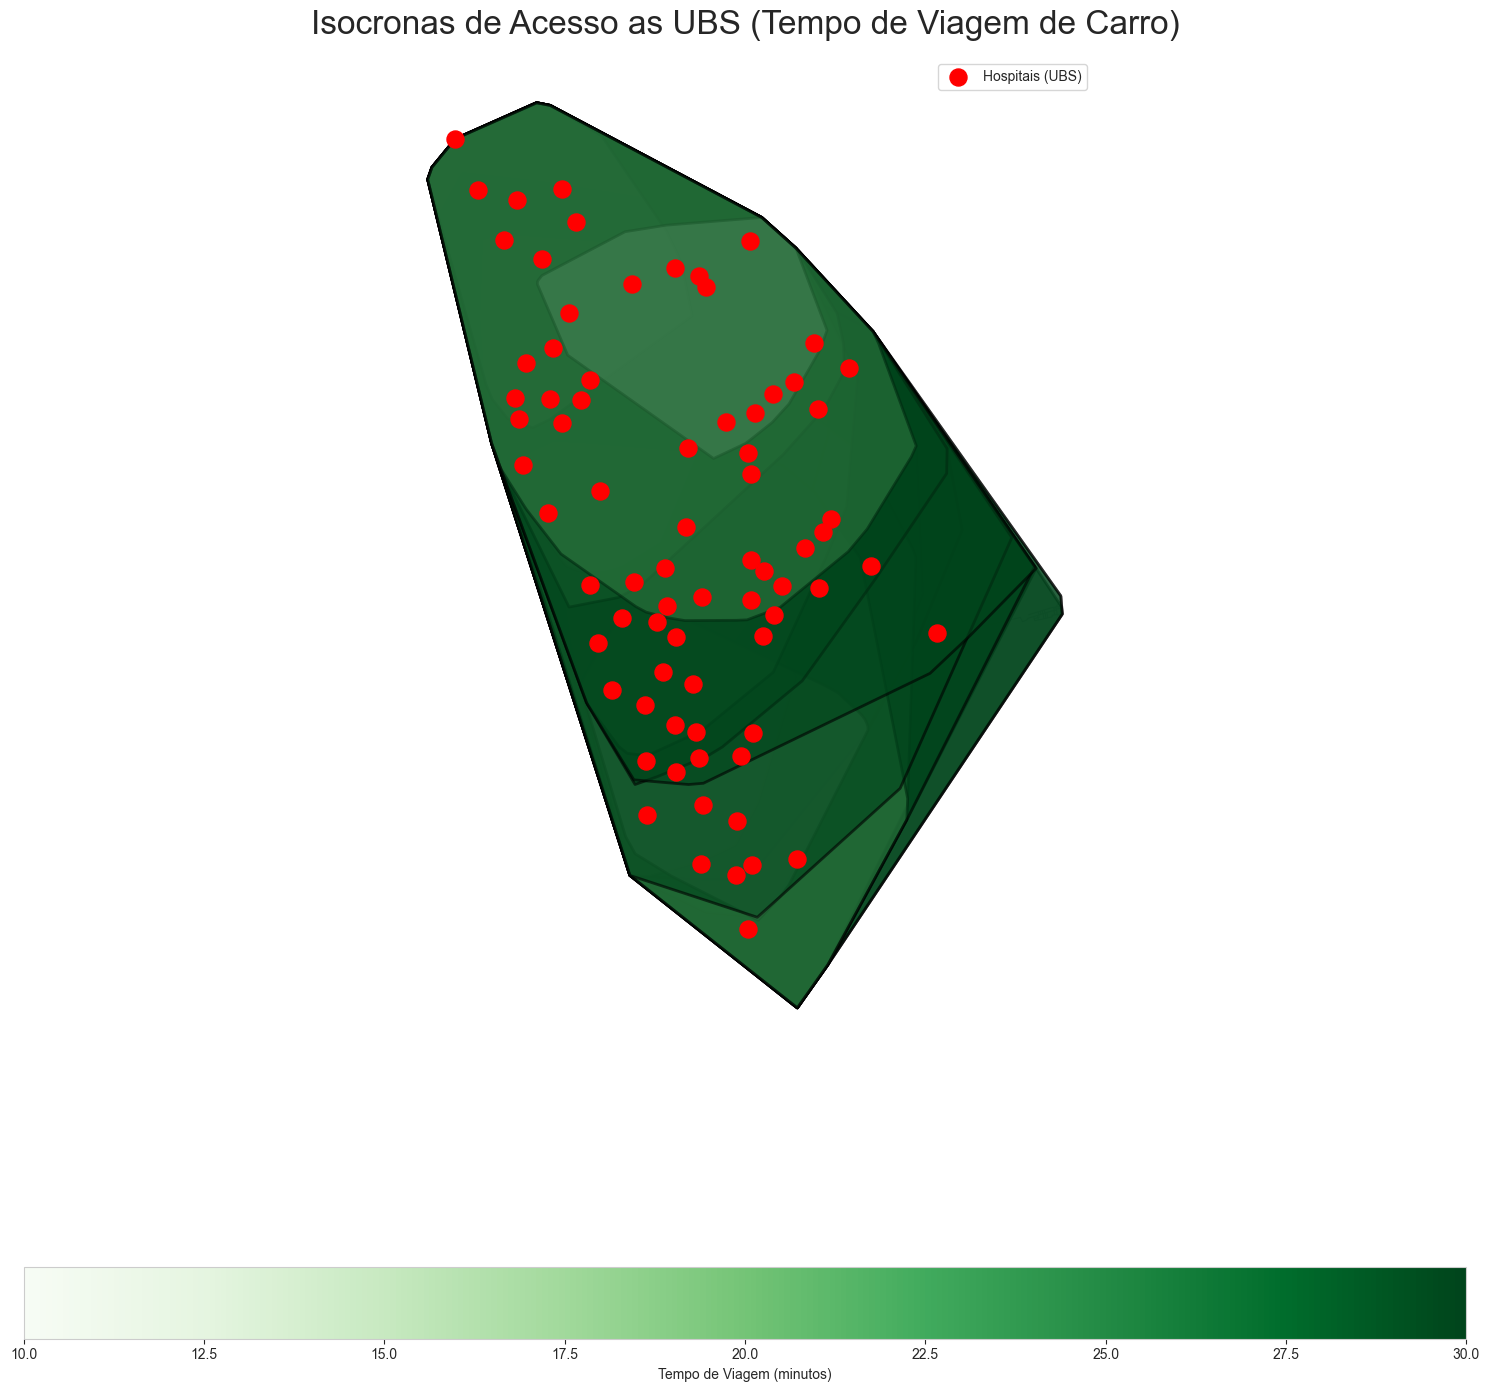

In [13]:
# Criar a figura e o eixo para o plot
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

# Plotar a malha viária (base do mapa)
gdf_rede_filtrada.plot(ax=ax, color='lightgray', linewidth=0.7, zorder=1)

# Ordena o GeoDataFrame para garantir que os polígonos maiores sejam desenhados primeiro
isocronas_gdf_sorted = isocronas_gdf.sort_values(by='tempo_min', ascending=False)

# Plotar as isócronas usando um mapa de cores (cmap)
# A coluna 'tempo_min' definirá a cor de cada polígono
isocronas_gdf.plot(
    ax=ax, 
    column='tempo_min', 
    cmap='Greens', # Mapa de cores em tons de verde
    alpha=0.6,     # Transparência
    linewidth=2,   # Borda do polígono
    edgecolor='black',
    legend=True,
    legend_kwds={'label': "Tempo de Viagem (minutos)", 'orientation': "horizontal"},
    zorder=2
)

# Plotar os pontos dos hospitais por cima de tudo
ubs_gdf.plot(
    ax=ax, 
    color='red', 
    markersize=150, 
    label='Hospitais (UBS)',
    zorder=3
)

# Adicionar título e legendas
ax.set_title('Isocronas de Acesso as UBS (Tempo de Viagem de Carro)', fontsize=24)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend()

# Ajustar o mapa para a área de interesse
ax.set_axis_off() # Remover eixos x e y para um visual mais limpo

plt.tight_layout()
plt.show()

## Conclusão

Este notebook demonstrou com sucesso um fluxo de trabalho completo para o cálculo de isócronas:
1.  **Dados de Entrada**: Utilizamos pontos de interesse (hospitais) e uma malha viária de uma fonte aberta e robusta (Overture Maps).
2.  **Processamento**: A biblioteca `city2graph` provou ser uma ferramenta extremamente eficiente para transformar dados vetoriais de ruas em um grafo ponderado, abstraindo a complexidade do `networkx` para esta tarefa específica.
3.  **Análise**: O cálculo das isócronas foi direto, permitindo-nos gerar polígonos de acessibilidade para múltiplos pontos e intervalos de tempo de forma iterativa.
4.  **Visualização**: O resultado final é um mapa claro e informativo que pode ser usado para análise de cobertura de serviços, planejamento urbano, logística, entre outros.

### Próximos Passos:
- **Análise de População**: Cruzar as isócronas com dados de densidade populacional para estimar quantas pessoas são atendidas por cada hospital em cada intervalo de tempo.
- **Modos de Transporte**: Repetir a análise para outros modos, como transporte público (se houver dados de GTFS) ou a pé (ajustando a velocidade).
- **Análise de Cobertura**: Calcular a porcentagem da área urbana ou da população que não tem acesso a um hospital em menos de 30 minutos.

In [14]:
# ===================================================================
# SEÇÃO 6: Exportar o Resultado para GeoJSON
# ===================================================================

# Definir o nome do arquivo de saída
output_filename = 'dados/overturemaps/resultado/isocronas_ubs_zu9.geojson'

# Exportar o GeoDataFrame para o formato GeoJSON
# É uma boa prática especificar a codificação para evitar problemas com caracteres especiais (acentos)
isocronas_gdf.to_file(
    output_filename, 
    driver='GeoJSON', 
    encoding='utf-8',
    crs='31983',
    engine='fiona'
)

print(f"Arquivo GeoJSON salvo com sucesso em: {output_filename}")


Arquivo GeoJSON salvo com sucesso em: dados/overturemaps/resultado/isocronas_ubs_zu9.geojson
